<a href="https://colab.research.google.com/github/thuyd12/Trolls-detection/blob/main/33_Trolls_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 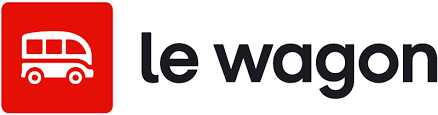

# Trolls detection

# Install Pycaret

a) Execute cell below to install pycaret for future need.

You will be asked to restart runtime. Please do and wait for a minute. Execute once again this cell, you should see "requirement already satisfied" on each row, if it's the case you are good to go.


In [ ]:
!pip install pycaret

## Data Discovery

a) Download [moderation.csv](https://drive.google.com/file/d/1twNqS0rd67DhURv2dZiOyjoeRf3s4q-f/view?usp=sharing) and upload it to Colab.
Load data into a `df` variable.

What are the features and the target?

In [ ]:
import pandas as pd

df = pd.read_csv("moderation.csv")
df

<details>
    <summary><i>Answer:</i></summary>

Features are:

- `node_id` ⇨ internal and unique id of each user

- `email` ⇨ the email used to register (other refers to emails other than the main ones)

- `has_picture_cover` ⇨ has the user added a picture to their profile?

- `has_linkedin` ⇨ has the user added their LinkedIn handle?

- `has_personal_url` ⇨ has the user added a link to their personal url?

- `has_instagram` ⇨ has the user added their Instagram handle?

- `tags` ⇨ the set of tags in the profile, separated by `;`

- `goals` ⇨ the set of goals chosen by the user, separated by `;`

- `nb_chars_in_bio` ⇨ the number of characters in the profile's bio


`is_unwanted` is the target.

</details>        




b) Data need to be cleaned.

- Replace NaN values in `nb_chars_in_bio` column by 0.
- Replace NaN values in `tags` and `goals` column by "".

Verify.

<details>
    <summary><i>Hint:</i></summary>

Use `.loc[]` and function `.isnull()`. 

</details>  

In [ ]:
df.loc[df['tags'].isnull(),'tags']

In [ ]:
df.loc[df['tags'].isnull(), 'tags'] = ''
df.loc[df['goals'].isnull(), 'goals'] = ''
df.loc[df['nb_chars_in_bio'].isnull(), 'nb_chars_in_bio'] = 0

In [ ]:
df.info()

c) How many profiles are non wanted? Is the dataset well balanced (as much as profiles in both classes) ?

In [ ]:
df["is_unwanted"].sum()

1000 out of 10000 are unwanted in the dataset. It's 10% versus 90%, the dataset is unbalanced.

d) Do you think that column `node_id` is relevant for our needs? 

<details>
    <summary><i>Hint:</i></summary>

node_id is a unique id for each Shapr user.
We can delete it.

</details>  

## Features engineering




a) How many email providers are there? 

Represent their distribution in the form of a histogram.

<details>
<summary><i>Hint</i></summary>
    ⟿  Plotly Express dispose de la fonction "histogram" qui permet de faire ce graph de distribution : https://plotly.com/python/histograms/

use color parameter to distinguish between providers
</details>

In [ ]:
import plotly.express as px

fig = px.histogram(df['email'], color=df['email'], orientation='h')
fig.show()

b) We now want to study the link between the 
email provider and the probability of being labeled as `unwanted`. 

Plot this probability in a chart.


<details>
<summary><i>Hint</i></summary>
    ⟿  use `groupby` and `mean` function to calculate probability of being `is_unwanted` by email provider.
    
    <br/>
    
    ⟿  we can use a `bar` chart of Plotly Express : https://plotly.com/python/bar-charts/
</details>

In [ ]:
proba = df.groupby("email")['is_unwanted'].mean() * 100
proba

In [ ]:
fig = px.bar(proba, color=proba.index, orientation='h')
fig.show()

c) Which email provider is linked to a higher probability of being a junk account? 

What about the lowest probability? 

Do you think the email provider is a good predictor?

Which statistical test could we do ?

<details>
<summary><i>Response</i></summary>

- icloud is the provider linked to the highest rate of unwanted accounts.

- On the other hand, it is the other operators, "Other", that are the least associated with undesirable accounts, could be professional emails.

- Overall, the explanatory variable "email" seems to have a low discriminatory power.

- An Anova test could tell us whether or not there are significant differences between email providers.

</details>

d) We want to study if having a `picture cover` decreases probability of being undesirable. 

Use code below and perform a statistical test. What do you conclude ?

At the end of the exercise, if you still have time you can perfom same test on other boolean feature as well.

<details>
<summary><i>Hint</i></summary>

- Use chi2 test on contingency table given below.

</details>

In [ ]:
# calculate contingency table
CT = pd.crosstab(index=df['has_picture_cover'], columns=df['is_unwanted'])
CT

In [ ]:
import scipy.stats as stats

# Perform Chi-squared test
chiRes = stats.chi2_contingency(CT)
# Details
print(f'p-value: {chiRes[1]}')

p-value is near 0, it means whatever level of risk, we reject null hypothesis. There is a significant difference between having or not a picture cover.

e) We want to study the link between `nb_chars_in_bio` and being unwanted or not.

What chart can you suggest?



f) Display a boxplot of `nb_chars_in_bio` per `is_unwanted`.

What can you say?


<details>
<summary><i>Hint</i></summary>
    ⟿  L'affichage peut utiliser la fonction "box" de Plotly Express : https://plotly.com/python/bar-plots/
</details>

In [ ]:
fig = px.box(df, x="nb_chars_in_bio", color='is_unwanted')
fig.show()

<details>
<summary><i>Answer</i></summary>

We observe that most trolls filled their bio with less than 50 letters. In other words, the majority of trolls put at most a short sentence as their bio.

Legitimate users, on the other hand, put in two to three times as much content.

It appears that this variable has a good discriminatory power.
</details>

g) We want to calculate `nb_tags` and `nb_goals` which correspond to number of tags and number of goals.

Create this two new columns.


<details>
<summary><i>Hint 1</i></summary>
function `count()` count number of times a character is found in a string
</details>
<br>

<details>
<summary><i>Hint 2</i></summary>
To apply a string function to a Serie, you need to use attribute `.str`, for example `df["tags"].str`
</details>
<br>

<details>
<summary><i>Answer</i></summary>
df["nb_tags"] = df["tags"].str.count(';')
</details>

In [ ]:
df["nb_tags"] = df["tags"].str.count(';')
df["nb_goals"] = df["goals"].str.count(';')

# Modeling

a) From `df` create a DataFrame `dataset` with `has_picture_cover`, `has_linkedin`, `has_twitter`, `has_personal_url`, `has_instagram`, `nb_chars_in_bio`, `nb_tags`, `nb_goals`,`is_unwanted`, `is_unwanted` columns. 

In [ ]:
dataset = df[["has_picture_cover", "has_linkedin", "has_twitter", "has_personal_url", "has_instagram", "nb_chars_in_bio", "nb_tags", "nb_goals",
               "is_unwanted"]]
dataset

b) As we have seen before, the dataset contains 9 times more normal users (`is_unwanted` worth 0) than trolls (`is_unwanted` worth 1).

Learning a model with this bias is not desirable, because whatever the user to be classified, answering "no-troll" would be enough to be right in 90% of cases!

To avoid this, we need to apply an "under-sampling" technique. This consists of randomly retaining a subsample of normal users.

Look carefully code below and execute it.



In [ ]:
# concatenate is_unwanted users and 1000 randomly selected wanted users
dataset = pd.concat([dataset[dataset['is_unwanted']==0].sample(1000),
                     dataset[dataset['is_unwanted']==1]])
dataset['is_unwanted'].value_counts()

c) Perform the 80% / 20% split of your dataset with the code below.

What does the `stratify` parameter mean? Why is it useful here?

Note that we didn't split between X, y and train / test. It's because we will use Pycaret for modeling part.

In [ ]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_unseen = train_test_split(dataset,
                                                 test_size=0.2,
                                                 stratify=dataset['is_unwanted'])

<details>
<summary><i>Answer:</i></summary>
The `stratify = dataset['is_unwanted']` parameter is important here because it ensures that the proportion of unwanted individuals remains the same after trimming between the train and the test. This is important because unlucky random slicing could result in a training dataset with no examples of any of the classes, making learning impossible
</details>
<br>



d) Now it's time to use <b>PyCaret</b>!

Complete the following code, justifying your choice for the value of `normalize`.

In [ ]:
from pycaret.classification import setup

xp = setup(data = dataset_train,
           test_data = dataset_unseen,
           target = "is_unwanted",
           normalize = True , 
           session_id = 42,
           silent = True)

b) Screen the PyCaret models and compare their performance by executing cell below.

Which model has the best accuracy?

In [ ]:
from pycaret.classification import compare_models

best_model = compare_models()

<details>
<summary><i>Answer:</i></summary>

The best model here is `logistic regression`. Based on the k-fold validation, we estimate that it has 72% accuracy in its predictions.

It also offers balanced recall and precision rates: 72% for these two metrics.

Looking at the performances of the other classifiers, we note in passing :

- several classifiers offer relatively similar performances at the top of the ranking, which seems to indicate a global convergence towards an optimum.

- we observe globally the Precision/Recall trade-off in the classifiers' scores: the increase of one corresponds to the decrease of the other. Indeed, each classifier has its own way of setting the threshold of acceptability of a prediction as "True". Varying this threshold is like trading False Positives for False Negatives.
</details>
<br>



c) Display matrix confusion using plot_model function.

Find correct syntax on your lecture.

In [ ]:
from pycaret.classification import plot_model

plot_model(best_model, plot='confusion_matrix')

d) To improve performance, it is possible to vary the hyper-parameters of the model.

This can be done with a simple call to the `tune_model` function, [described here](https://pycaret.org/tune-model/).

Execute cell below. Is it better?

In [ ]:
from pycaret.classification import tune_model

best_model_tuned = tune_model(best_model)

<details>
<summary><i>Answer:</i></summary>

Each fold is a specific split on data. 

If we look at Mean row, performance is not really better.
Tuning hyper parameters here was not necessary.
</details>
<br>




e) We propose to provide an a posteriori explanation of the classifier operation.

To obtain the features importance graph , call the function plot_model with the model of your choice and add the argument plot="feature".

How do you interpret these values?

In [ ]:
plot_model(best_model,'feature')

<details>
<summary><i>Answer:</i></summary>

- The `nb_tags_0` variable is the most important one for detecting a troll. This is not surprising, as this one of the most "expensive" to fill in.

- As far as online presence is concerned, the presence of a personal website (`has_personal_url_1`) or a professional page (`has_linkedin_1`) are more discriminating than the membership to a non-professional social network (`has_twitter_1` and `has_instagram_1`).

- providing a profile picture (`has_picture_cover_0`) or tags/goals (`has_tag_1`/`has_goal_1`) when registering is also useful, just like providing a personal or professional page.

</details>
<br>